In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, truncexpon, truncnorm, nbinom, norm
import pandas as pd
import time
import torch
from torch import nn
from torch import distributions
from torch import rand
from torch import autograd
from torch import optim

In [2]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)
dtype = torch.float64
device = torch.device("cpu")

In [3]:
data = pd.read_csv('data/covid19model.csv')

# Initialization

In [4]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)


## Initialize latent variables/parameters

In [5]:
tau_prime = torch.tensor(np.random.exponential(1 / 0.03), requires_grad=True, device=device, dtype=dtype)
phi_prime = torch.tensor(truncnorm.rvs((0 - 25) / 10, (np.inf - 25) / 10, loc=25, scale=10), requires_grad=True,
                         device=device,
                         dtype=dtype)  # has to be positive, between 0-50 --> uniform # dispersion (shape) parameter for observations
R0_prime = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True,
                        device=device,
                        dtype=dtype)  # probably gamma or inverse gamma distribution (compare to truncated normal) # initial reproduction number
alpha_prime = torch.tensor(
    truncnorm.rvs((0 - 1 / 100) / 1 / 100, (5 / 100 - 1 / 100) / 1 / 100, loc=1 / 100, scale=1 / 100),
    requires_grad=True, device=device,
    dtype=dtype)  # uniform distribution between (0-5%) # probability to get hospitalized
sigma_prime = torch.tensor(truncnorm.rvs((0 - 0.1) / 0.3, (0.5 - 0.1) / 0.3, loc=0.1, scale=0.3), requires_grad=True,
                           device=device,
                           dtype=dtype)  # positive, tricky, gamma or inverse gamma, log normal  --> try something out, large sigma--> prone to overfitting # standart deviation of random walk step

epsilon_t = torch.zeros(num_observations, device=device)
epsilon_t[0] = torch.distributions.Normal(cero, sigma_prime.detach()).rsample()
for t in range(1, num_observations):
    epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].detach(), sigma_prime.detach()).rsample()
epsilon_t.requires_grad_(True)


tensor([-0.4062, -0.6443, -0.7379, -0.5224, -1.0346, -0.8584, -0.9320, -1.0597,
        -1.2271, -2.1625, -1.9980, -1.9351, -2.5766, -2.6399, -2.8520, -2.3127,
        -2.2400, -2.1588, -1.6862, -1.7545, -2.1455, -2.1636, -2.2423, -1.9797,
        -1.7461, -1.8958, -2.0178, -1.7697, -1.1899, -1.5608, -1.2986, -0.9878,
        -1.1975, -0.8651, -1.3561, -1.3298, -1.3777, -1.6734, -1.5581, -1.3892,
        -0.9920, -1.1048, -1.2804, -1.7002, -1.6482, -1.9254, -1.9525, -1.6132,
        -1.9811, -1.7413, -1.5891, -1.5620, -1.2712, -1.5568, -1.1379, -1.0850,
        -1.0561, -0.6375, -0.5553, -0.4397, -0.1980, -0.2442, -0.0438,  0.0886,
        -0.0346,  0.0927,  0.2458, -0.2554, -0.6296, -1.1790, -1.6244, -1.6822,
        -1.5316, -1.8503, -1.9239, -2.1913, -2.6200, -2.6891, -2.6408, -2.6501,
        -2.7506, -3.0649, -3.4478, -3.4980, -4.0263, -4.1605, -4.3302, -4.1965,
        -4.3513, -4.5640, -4.2001, -4.0767, -4.0118, -4.0224, -3.5900, -3.1960,
        -3.5165, -3.0897, -2.7679, -2.05

# Define Forward Pass

In [6]:
def bij_transform(prime, lower, upper):
    # Recieves a value in [-inf, inf] and returns value in [low, upper]
    bij = 1 / (1 + torch.exp(-prime))
    scale = upper - lower
    return scale * bij + lower


def bij_transform_inf(prime):
    return torch.exp(prime)


In [7]:
def calc_prior_loss(tau, phi, R0, alpha, sigma):
    # log likelihood wrt. our prior ("regularisation")
    # ll stands for log-likelihood
    multiplier = 10
    ll = torch.tensor(0.0, device=device)

    ll += (tau - (1 / 0.03)) ** 2 * multiplier

    ll += (phi - 25) ** 2 * multiplier

    ll += (R0 - 3.6) ** 2 * multiplier

    ll += (alpha - 0.01) ** 2 * multiplier

    ll += (sigma - 0.1) ** 2 * multiplier

    return ll


In [8]:
def seed_init_infect(y):
    # Initialize newly_infected, cumulative_infected, St
    newly_infected = torch.zeros(num_observations, device=device, dtype=dtype)  # number of newly infected
    cumulative_infected = torch.zeros(num_observations, device=device)  # cumulative number of infected

    St = torch.zeros(num_observations, device=device)  # fraction of susceptible population
    # seed initial infection / impute first num_impute days
    newly_infected[0:num_impute] = y.clone()
    cumulative_infected[0] = 0.
    cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
    St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in
                                     cumulative_infected[0:num_impute].clone()])
    return newly_infected, cumulative_infected, St


In [9]:
def calc_Rt(R0, epsilon_t, sigma, ll):
    # Initialize eta_t
    eta_t = torch.zeros(num_observations, device=device)  # transformed reproduction number

    # calculate Rt: the basic reproduction number
    # basic reproduction number as a latent random walk
    beta_0 = torch.log(R0)
    eta_t[0] = beta_0

    #loss1 = 0
    #loss2 = 0
    #for t in range(1, num_observations):
    #    dist_epsilon_t = torch.distributions.Normal(epsilon_t[t - 1], sigma)
    #    ll += dist_epsilon_t.log_prob(epsilon_t[t])
    #    loss1 += dist_epsilon_t.log_prob(epsilon_t[t])

    loc = epsilon_t[:-1].clone()
    scale = sigma * torch.ones(num_observations-1)
    mvn = distributions.multivariate_normal.MultivariateNormal(loc, scale_tril=torch.diag(scale))
    ll += mvn.log_prob(epsilon_t[1:].clone())
    #loss2 = mvn.log_prob(epsilon_t[1:].clone())

    #print(loss1, loss2)

    eta_t[1:num_observations] = beta_0 + epsilon_t[0:num_observations - 1].clone()
    Rt = torch.exp(eta_t)
    return Rt, ll


In [10]:
def calc_infections(cumulative_infected, newly_infected, St, Rt):
    # Initialize effectively_infectious
    effectively_infectious = torch.zeros(num_observations, device=device)  # effective number of infectious individuals

    # calculate infections
    for t in range(num_impute, num_observations):
        # Update cumulative newly_infected
        cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
        # Adjusts for portion of pop that are susceptible
        St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
        # effective number of infectous individuals
        ni_temp = newly_infected[:t].view(1, 1, -1).clone()
        si_temp = torch.flip(serial_interval, (0,))[-t:].view(1, 1, -1)
        effectively_infectious[t] = torch.nn.functional.conv1d(ni_temp, si_temp)

        newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()
    return newly_infected


In [11]:
def calc_hospit(newly_infected, alpha):
    # Initialize expected_daily_hospit
    expected_daily_hospit = torch.zeros(num_observations, device=device)  # expected number of daily hospitalizations

    # calculate expected number of hospitalizations
    expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
    for t in range(1, num_observations):
        ni_temp = newly_infected[:t].view(1, 1, -1)
        pi_temp = torch.flip(pi, (0,))[-t - 1:-1].view(1, 1, -1)
        expected_daily_hospit[t] = torch.nn.functional.conv1d(ni_temp, pi_temp)
    expected_daily_hospit = alpha * expected_daily_hospit
    return expected_daily_hospit


In [12]:
def compare_results(expected_daily_hospit, phi, ll):
    # compare observed hospitalizations to model results
    # likelihood of the data wrt. to the model

    for i in range(0, num_observations):
        p = 1 / (1 + expected_daily_hospit[i] / phi)
        if p == 1:
            p = p.clone() - torch.tensor(2.225e-5)
        if p < 2.225e-5:
            p = p.clone() + torch.tensor(2.225e-5)
        dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p - torch.tensor(2.225e-5))
        ll += dist.log_prob(observed_daily_hospit[i])
    return ll


In [13]:
def forward_pass():
    # Initialize y
    tau = bij_transform(tau_prime, lower=0, upper=200)
    y = torch.distributions.exponential.Exponential(1 / tau).rsample()
    R0 = bij_transform(R0_prime, lower=2, upper=5)
    phi = bij_transform(phi_prime, lower=1, upper=50)
    alpha = bij_transform(alpha_prime, lower=0, upper=0.05)
    sigma = bij_transform(sigma_prime, lower=0, upper=0.5)

    # Calculate prior loss
    ll = calc_prior_loss(tau, phi, R0, alpha, sigma)

    # Seed initial infections
    newly_infected, cumulative_infected, St = seed_init_infect(y)

    # Calculate Rt & random walk loss
    Rt, ll = calc_Rt(R0, epsilon_t, sigma, ll)

    # Calculate infections
    newly_infected = calc_infections(cumulative_infected, newly_infected, St, Rt)

    # Calculate expected hospitalizations
    expected_daily_hospit = calc_hospit(newly_infected, alpha)

    # Compare observed hospitalizations to model results
    ll = compare_results(expected_daily_hospit, phi, ll)

    return expected_daily_hospit, Rt, ll, tau, R0, phi, alpha, sigma


# Optimization



Time Step: 0 || Loss: 192885.953125

R0:4.721550867919079  grad:9962.66295482664
alpha:0.02512499717849155  grad:4442.178666519853
phi:49.99999999989285  grad:-1.345771248032787e-07
sigma:0.2862575342869815  grad:-2.32203120277755
epsilon_t.mean:-0.37735244631767273  grad.mean:457.2751159667969
tau:199.9999999939194  grad:2.0526147805197955e-05

This Run:  0.91908860206604 seconds


Time Step: 5 || Loss: 171035.609375

R0:4.707727237525127  grad:11537.043124873784
alpha:0.024839026059239763  grad:4679.199935637983
phi:49.99999999989285  grad:-1.8223663401916173e-07
sigma:0.2862591216767202  grad:-3.0218510176320708
epsilon_t.mean:-0.37976521253585815  grad.mean:505.6142883300781
tau:199.9999999939194  grad:2.0610527632185137e-05

This Run:  0.7814211845397949 seconds


Time Step: 10 || Loss: 161268.078125

R0:4.692791275348498  grad:11024.746994137982
alpha:0.024548664419079526  grad:4495.377061305105
phi:49.99999999989285  grad:-2.0207879874962236e-07
sigma:0.2862611436239316  grad:

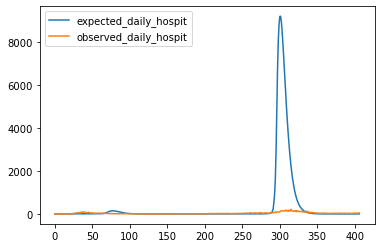

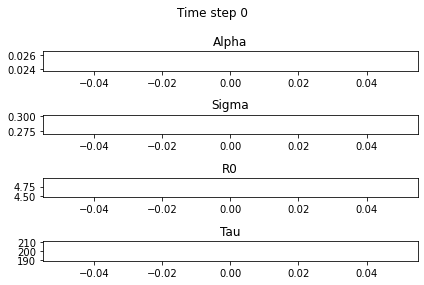

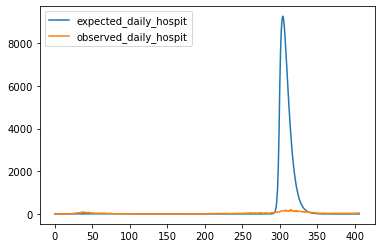

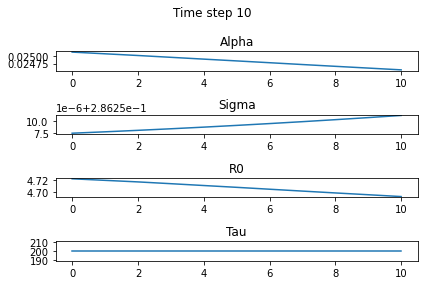

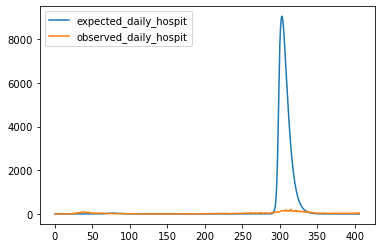

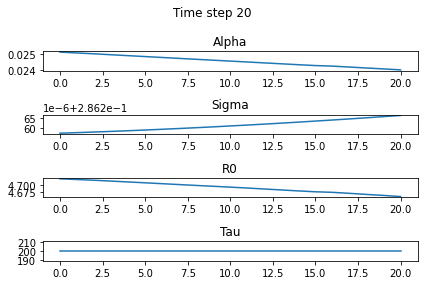

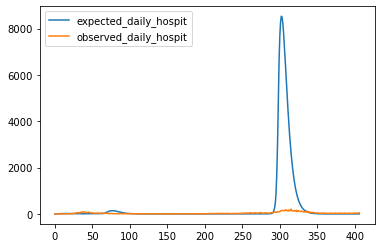

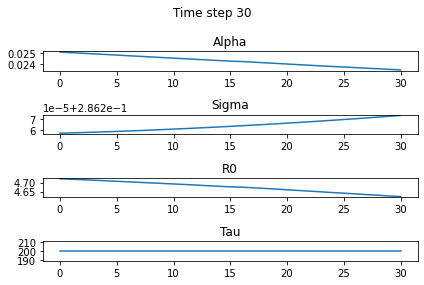

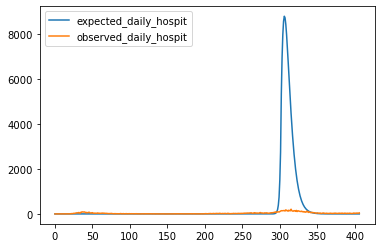

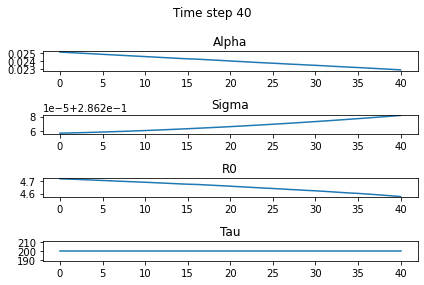

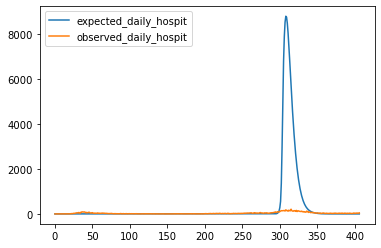

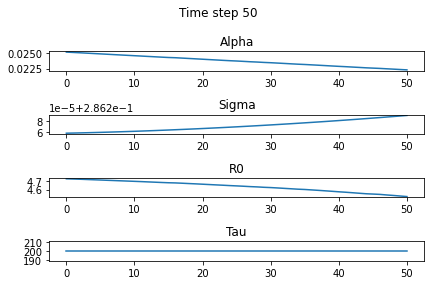

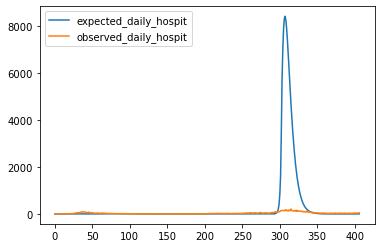

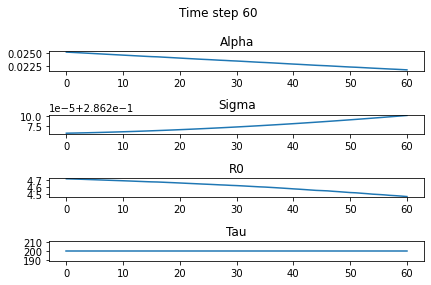

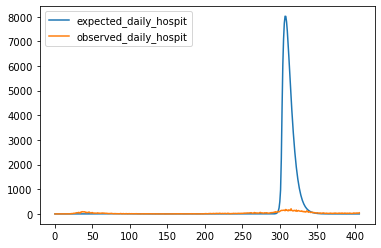

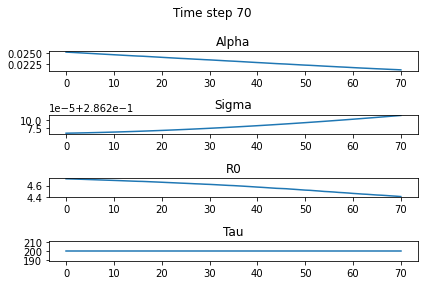

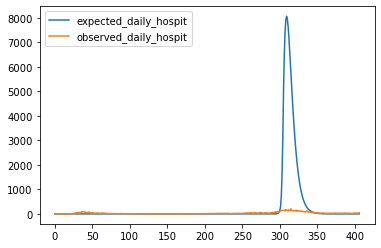

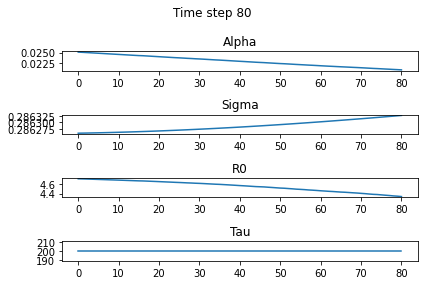

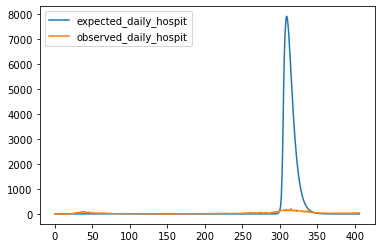

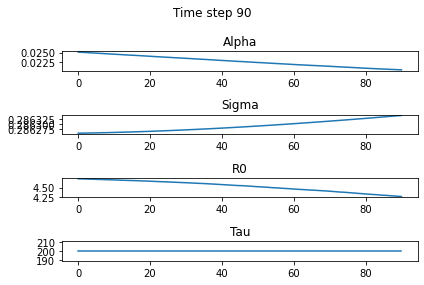

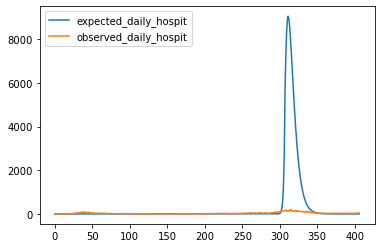

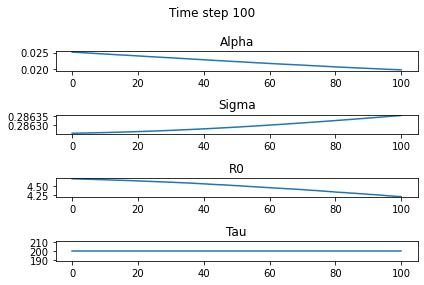

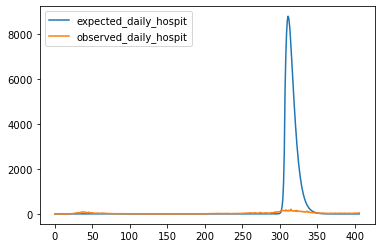

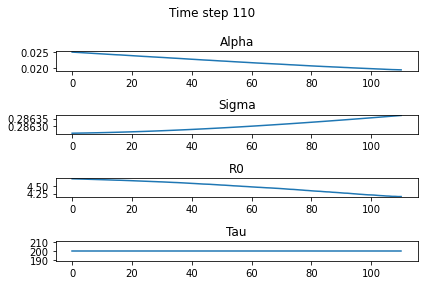

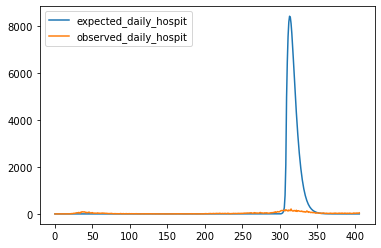

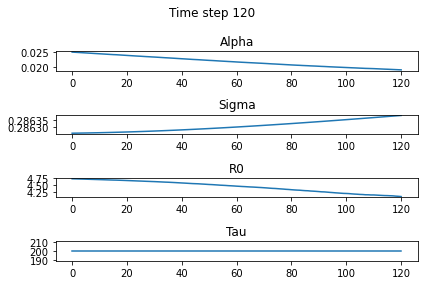

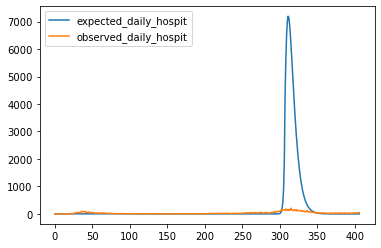

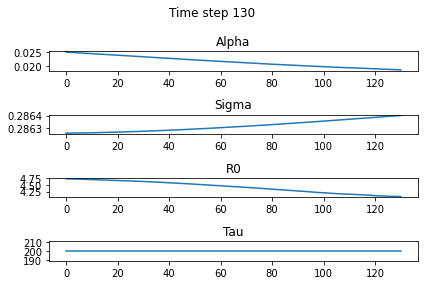

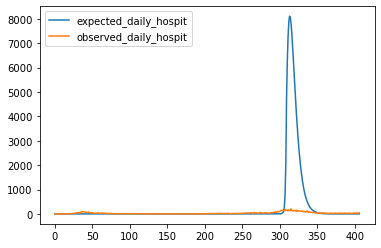

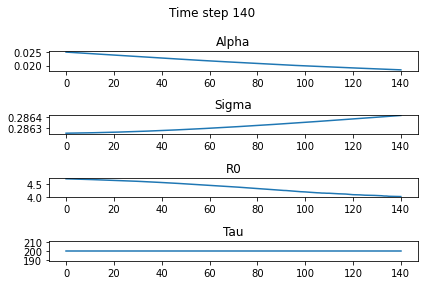

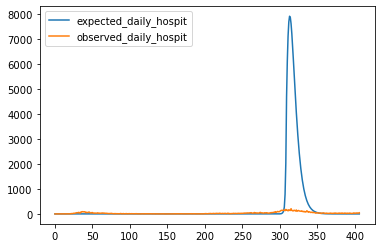

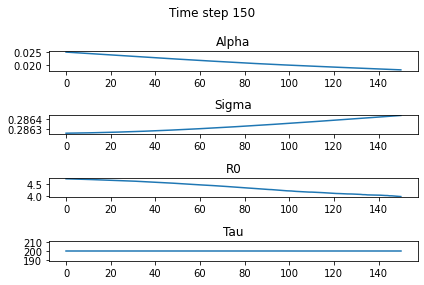

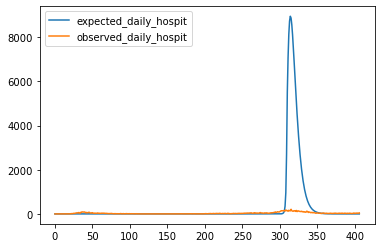

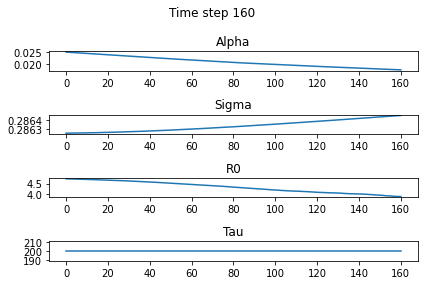

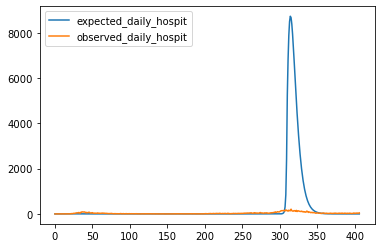

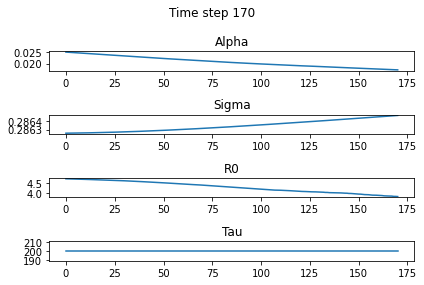

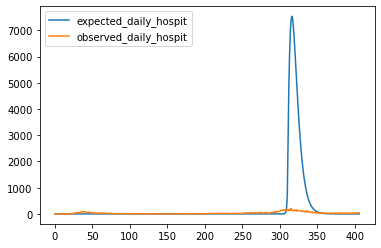

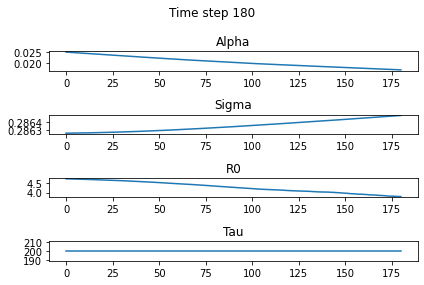

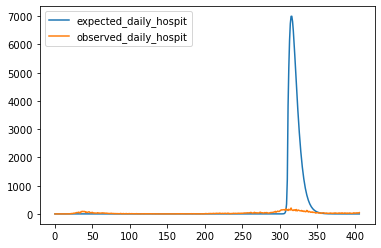

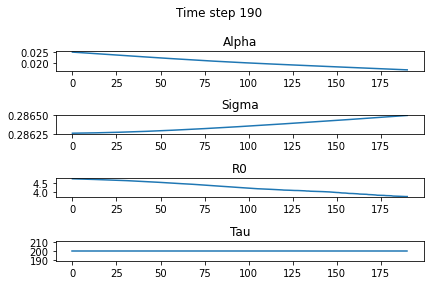

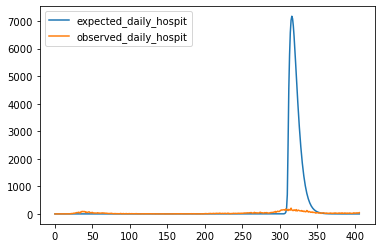

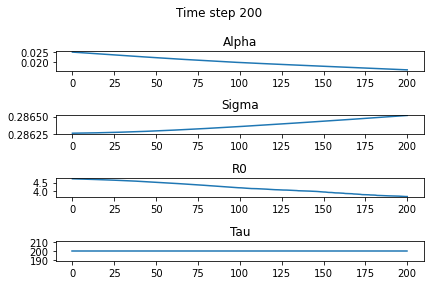

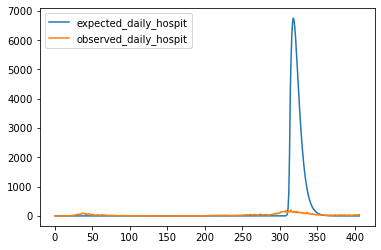

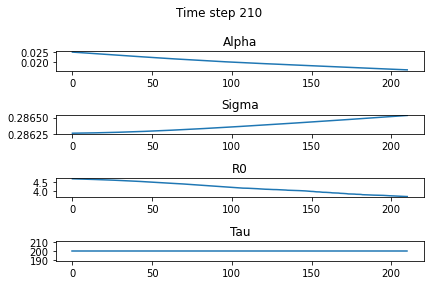

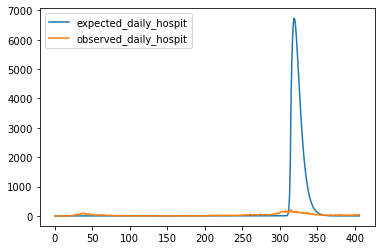

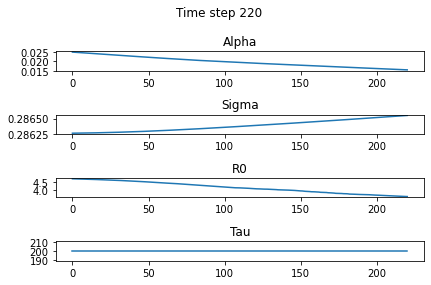

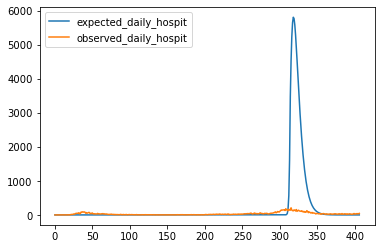

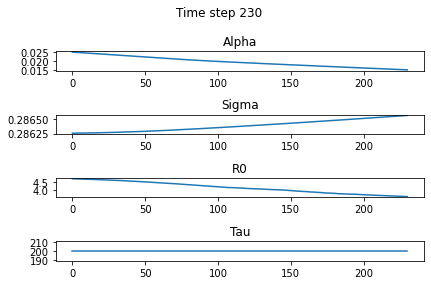

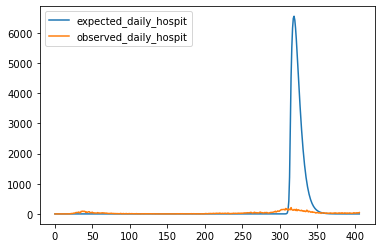

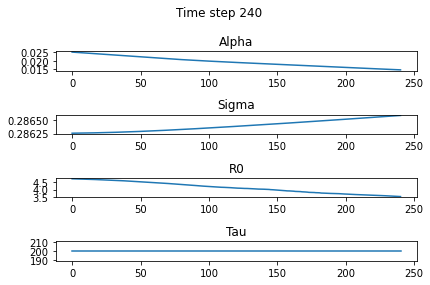

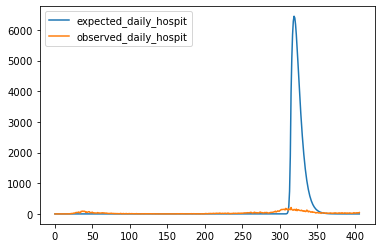

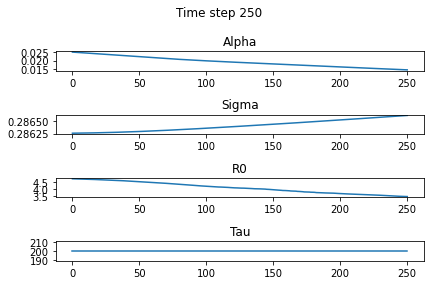

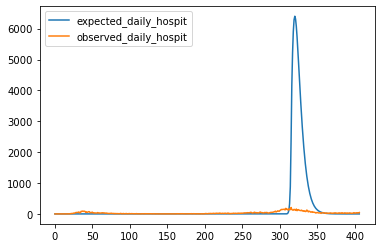

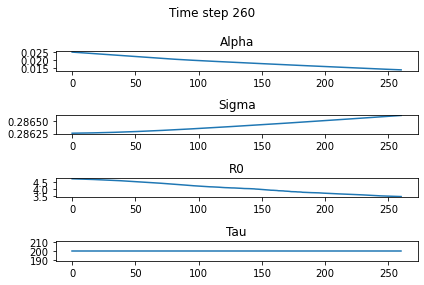

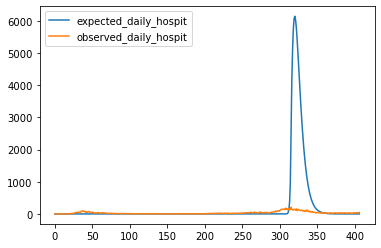

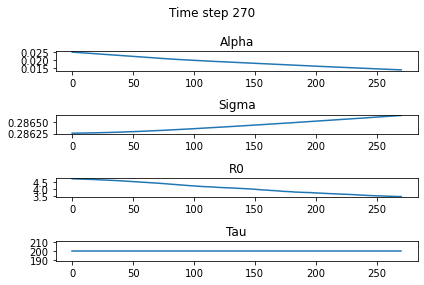

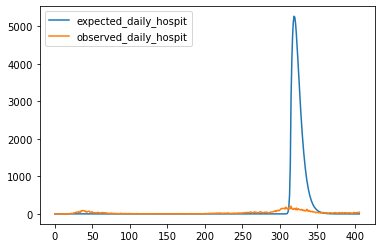

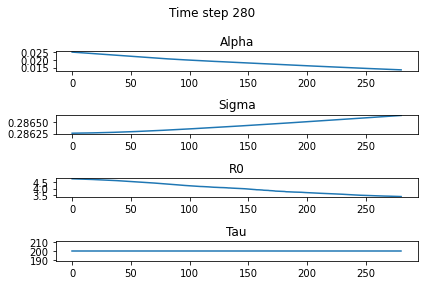

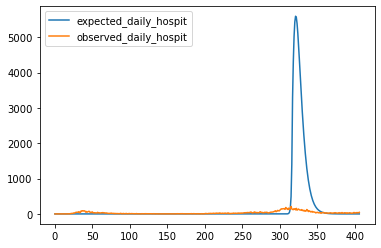

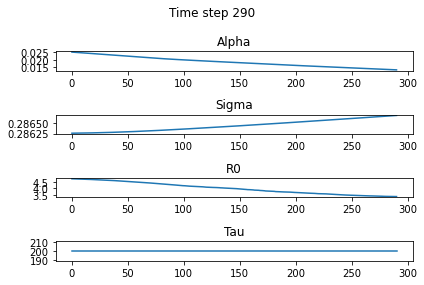

In [ ]:
# Visualization initialization
alpha_vis = []
sigma_vis = []
R0_vis = []
tau_vis = []

learning_rate = 1e-6
epochs = 1000
complete_time = time.time()

for k in range(epochs):
    start_time = time.time()
    decay = (1 - (k / (epochs * 1e5))) ** 2
    learning_rate = learning_rate * decay

    # forward pass - calculate expected_daily_hospit
    expected_daily_hospit, Rt, ll, tau, R0, phi, alpha, sigma = forward_pass()

    # backward pass
    loss = ll
    loss.backward()

    if k % 5 == 0:
        print(
            f'\n\nTime Step: {k} || Loss: {loss}\n\nR0:{R0}  grad:{R0_prime.grad}\nalpha:{alpha}  grad:{alpha_prime.grad}\n'
            f'phi:{phi}  grad:{phi_prime.grad}\nsigma:{sigma}  grad:{sigma_prime.grad}'
            f'\nepsilon_t.mean:{epsilon_t.mean()}  grad.mean:{epsilon_t.grad.mean()}\ntau:{tau}  grad:{tau_prime.grad}\n')
        print("This Run:  %s seconds" % (time.time() - start_time))
    with torch.no_grad():  # this part is SGD. can also replace with loss.step
        tau_prime -= learning_rate * tau_prime.grad
        phi_prime -= learning_rate * phi_prime.grad
        R0_prime -= learning_rate * R0_prime.grad
        alpha_prime -= learning_rate * alpha_prime.grad
        sigma_prime -= learning_rate * sigma_prime.grad
        epsilon_t -= learning_rate * epsilon_t.grad

        tau_prime.grad = None
        phi_prime.grad = None
        R0_prime.grad = None
        alpha_prime.grad = None
        sigma_prime.grad = None
        epsilon_t.grad = None

    # Visualization
    alpha_vis.append(alpha)
    sigma_vis.append(sigma)
    R0_vis.append(R0)
    tau_vis.append(tau)

    if k % 10 == 0:
        plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
        plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
        plt.legend()

        fig, axs = plt.subplots(4)
        fig.suptitle(f'Time step {k}')
        axs[0].plot(alpha_vis)
        axs[0].title.set_text('Alpha')
        axs[1].plot(sigma_vis)
        axs[1].title.set_text('Sigma')
        axs[2].plot(R0_vis)
        axs[2].title.set_text('R0')
        axs[3].plot(tau_vis)
        axs[3].title.set_text('Tau')
        fig.tight_layout()
        plt.show()


print("Complete Run:  %s seconds" % (time.time() - complete_time))